In [1]:
#!/usr/bin/env python
import sys
import pickle
import argparse
import numpy as np
import pandas as pd
from timeit import default_timer
from importlib import import_module
from contextlib import contextmanager
from scipy.stats import mode

sys.path.append('.')
from mcmc import mcmc_adg, mcmc_ara
from aps import aps_adg, aps_ara
from aps_annealing import aps_adg_ann

In [2]:
p = import_module(f'data.prob2')

In [3]:
p_a = pd.read_csv('results/prob2_p_a.csv')
p_a = p_a.drop(['d'], axis=1)
p_a = p_a.values
p_a

array([[0.065, 0.068, 0.064, ..., 0.015, 0.017, 0.007],
       [0.297, 0.26 , 0.213, ..., 0.   , 0.   , 0.   ],
       [0.327, 0.29 , 0.231, ..., 0.   , 0.   , 0.   ],
       ...,
       [1.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

## Monte Carlo

In [4]:
psi_d = np.zeros((len(p.d_values)), dtype=float)
iters = 1000
for i, d in enumerate(p.d_values):
    sample = np.random.choice(p.a_values, p = p_a[i], size = iters)
    theta_d = np.array([p.prob(d, a) for a in sample])[:,0]
    psi_d[i] = p.d_util(d, theta_d).mean()
d_opt = p.d_values[psi_d.argmax()]

In [5]:
d_opt

75

## APS

In [52]:
import matplotlib.pyplot as plt

def plot_hist(d_dist, i, J):
    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x=d_dist, bins=p.d_values+5, color='#0504aa',
                                alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    text = 'APS. Inverse Temp: ' + str(J)
    plt.title(text)
    plt.ylim((0,50000))
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    #plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.savefig('gif/img_' + str(i) + '.png', format='png', dpi=600)
    plt.show()
    
    

In [53]:
def propose(x_given, x_values):
    if x_given == x_values[0]:
        return( np.random.choice([x_values[1], x_values[-1]],
        p=[0.5, 0.5]) )

    if x_given == x_values[-1]:
        return( np.random.choice([x_values[0], x_values[-2]],
        p=[0.5, 0.5]) )

    idx = list(x_values).index(x_given)
    return( np.random.choice([x_values[idx+1], x_values[idx-1]],
    p=[0.5, 0.5]) )

In [54]:
def propose2(x_given, x_values):
    np.random.choice(x_values)

In [55]:
def iter_mcmc(J, d_sim, theta_sim):
    d_tilde = propose(d_sim, p.d_values)
    a_tilde = np.random.choice(p.a_values, p=p_a[p.d_values == d_tilde, :][0], size = J)
    theta_tilde = np.array([p.prob(d_tilde, a) for a in a_tilde])[:,0]

    num = p.d_util(d_tilde, theta_tilde)

    den = p.d_util(d_sim, theta_sim)

    quot = np.prod(num/den)


    if np.random.uniform() <= quot:
        return d_tilde, theta_tilde
    else:
        return d_sim, theta_sim

499


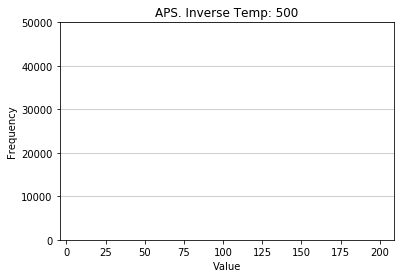

999


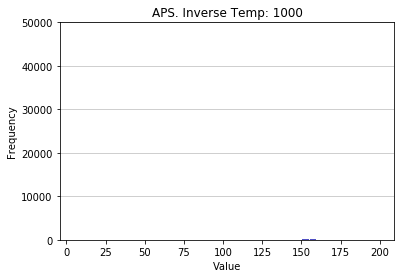

1499


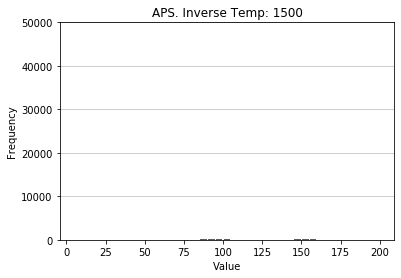

1999


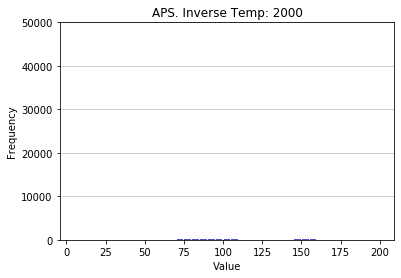

2499


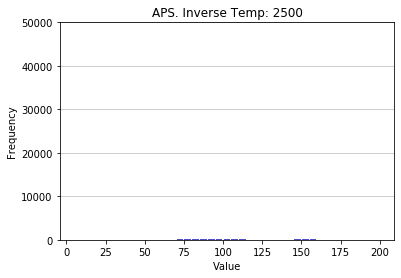

2999


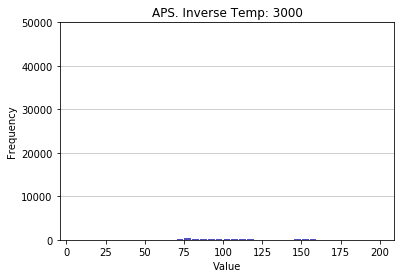

3499


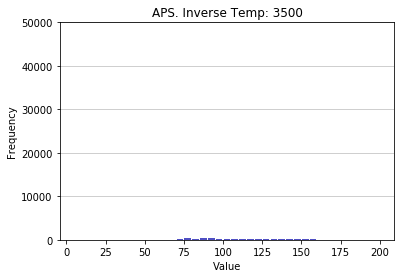

In [ ]:
J = 1
J_grid = range(1, 100001)
d_sim = np.zeros(len(J_grid), dtype = int)
d_sim[0] = np.random.choice(p.d_values)
a_sim = np.random.choice(p.a_values, p=p_a[p.d_values == d_sim[0], :][0], size = J)
theta_sim = np.array([p.prob(d_sim[0], a) for a in a_sim])[:,0]
##
for i, J in enumerate(J_grid):
    
    d_sim[i], theta_sim = iter_mcmc(J, d_sim[i-1], theta_sim)
    theta_sim = np.append(theta_sim, np.random.choice(theta_sim)) 
    if J%500 == 0:
        print(i)
        plot_hist(d_sim[:i], i, J)
        

## Backups

In [201]:
d_sim = np.zeros(N_aps, dtype = int)
d_sim[0] = 160
a_sim = np.random.choice(p.a_values, p=p_a[p.d_values == d_sim[0], :][0], size = J)
theta_sim = np.array([p.prob(d_sim[0], a) for a in a_sim])[:,0]
##
for i in range(1,N_aps):
    ## Update d
    d_tilde = propose(d_sim[i-1], p.d_values)
    a_tilde = np.random.choice(p.a_values, p=p_a[p.d_values == d_tilde, :][0], size = J)
    theta_tilde = np.array([p.prob(d_tilde, a) for a in a_tilde])[:,0]

    num = p.d_util(d_tilde, theta_tilde)

    den = p.d_util(d_sim[i-1], theta_sim)

    
    quot = np.prod(num/den)
    print(quot, d_tilde)


    if np.random.uniform() <= quot:
        d_sim[i] = d_tilde
        a_sim = a_tilde
        theta_sim = theta_tilde
    else:
        d_sim[i] = d_sim[i-1]

    if True:
        if i%1000 == 0:
            print(i)
            plot_hist(d_sim[:i])

d_dist = d_sim[int(burnin*N_aps):]
d_opt = mode(d_dist)[0]


'''
d_sim = np.zeros(N_aps, dtype = int)
d_sim[0] = 160
a_sim = np.random.choice(p.a_values, p=p_a[p.d_values == d_sim[0], :][0], size = J)
theta_sim = np.array([p.prob(d_sim[0], a) for a in a_sim])[:,0]
##
for i in range(1,N_aps):
    d_sim[i], theta_sim = iter_mcmc(J, d_sim[i-1], theta_sim)

    if i%100 == 0:
        print(i)
        plot_hist(d_sim[:i])
'''

0.5843754074112638 165
0.5919481935334605 170
0.5919481935334605 170
1.7112287534992727 160
1.7346766888483809 155
0.576476300413385 160
0.5843754074112638 165
0.5919481935334605 170
1.689337024630944 165
0.5919481935334605 170
0.5992150579354423 175
1.689337024630944 165
0.5919481935334605 170
1.7112287534992727 160
1.7346766888483809 155
0.576476300413385 160
1.7346766888483809 155
1.7598550586990709 150
1.7869651126704975 145
0.5596080152377001 150


KeyboardInterrupt: 